# Data preparation

In [1]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import altair as alt
from sklearn.cluster import KMeans
import re
from wordcloud import WordCloud


# Show all columns in dataframes
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

np.seterr(invalid="ignore");

In [2]:
# phila bounds
phl_bound = gpd.read_file("data/Yelp API/phl_bound.geojson")
phl_neigh = gpd.read_file("https://raw.githubusercontent.com/opendataphilly/open-geo-data/master/Neighborhoods_Philadelphia/Neighborhoods_Philadelphia.geojson")
phl_tract = gpd.read_file("data/Yelp API/census-tracts.geojson")

In [3]:
phl_bound_proj = phl_bound.to_crs(2272)
phl_neigh_proj = phl_neigh.to_crs(2272)
phl_tract_proj = phl_tract.to_crs(2272)

I concatenate neighborhood and tract names to create 384 sub-neighborhoods that still have recognizable neighborhood names.

In [4]:
# Copying the DataFrame
tract = phl_tract_proj.copy()

# Concatenating 'neighborhood_name' and 'tract_id' into a new column 'nb_name'
tract['nb_name'] = tract['neighborhood_name'] + " " + tract['tract_id'].astype(str)

tract["nb_name"].head()

0    Center City East 01
1    Center City East 02
2    Center City West 01
3    Center City West 02
4    Center City West 03
Name: nb_name, dtype: object

I calculate areas for each neighborhood so we can later calculate counts of amenities by square mile

In [5]:
tract = tract.copy()
# Calculate area in square meters
tract['area_m2'] = tract['geometry'].area

# Convert area to square miles (1 square mile = 2,589,988.11 square meters)
tract['area_mi2'] = tract['area_m2'] / 27878400

In [6]:
tract = tract[["nb_name", "area_mi2", "geometry"]]

I repeat the process for neighborhoods, first selecting and renaming the relevant columns from the projected neighborhood object. 

In [7]:
neigh = phl_neigh_proj[["mapname", "geometry"]].copy()
neigh["nb_name"] = neigh["mapname"]

I then calculate the area of each neighborhood

In [8]:
# Calculate area in square meters
neigh['area_m2'] = neigh['geometry'].area

# Convert area to square miles (1 square mile = 2,589,988.11 square meters)
neigh['area_mi2'] = neigh['area_m2'] / 27878400

neigh = neigh[["area_mi2", "nb_name", "geometry"]]

## Read in amenity files

In [9]:
# amenities
restaurants = gpd.read_file("data/Yelp API/restaurants.geojson")
parks = gpd.read_file("data/Yelp API/parks.geojson")
education = gpd.read_file("data/Yelp API/education.geojson")
grocery = gpd.read_file("data/Yelp API/grocery.geojson")
entertainment = gpd.read_file("data/Yelp API/entertainment.geojson")
nightlife = gpd.read_file("data/Yelp API/nightlife.geojson")
shopping = gpd.read_file("data/Yelp API/shopping.geojson")
healthcare = gpd.read_file("data/Yelp API/healthcare.geojson")
historic = gpd.read_file("data/Yelp API/historic_landmarks.geojson")
kids = gpd.read_file("data/Yelp API/kids.geojson")
arts = gpd.read_file("data/Yelp API/perf_arts.geojson")
beauty = gpd.read_file("data/Yelp API/beauty.geojson")

# Data Cleaning

## Restaurants

In [10]:
# Filter and create a copy to avoid SettingWithCopyWarning
food_desc = restaurants.copy()

# Create a new column 'desc_1'
food_desc["desc_1"] = food_desc['alias'].str.split(',').str[0].str.strip().str.lower()
food_desc["desc_2"] = food_desc['alias'].str.split(',').str[1].str.strip().str.lower()
food_desc["desc_3"] = food_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [11]:
len(food_desc)

2697


### First word in "alias"

In [14]:
# Group by 'desc_1' and count, then convert to DataFrame
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
108,pizza,320
36,chinese,198
118,restaurants,182
45,delis,161
124,seafood,101
17,breakfast_brunch,88
77,hotdogs,84
100,newamerican,81
122,sandwiches,77
58,fooddeliveryservices,75


### Second word in "alias"

In [15]:
# Group by 'desc_2' and count, then convert to DataFrame
food_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_2,count
111,sandwiches,120
12,breakfast_brunch,86
64,hotdogs,79
17,burgers,78
112,seafood,73
28,chicken_wings,66
131,tradamerican,65
72,italian,44
98,pizza,42
27,cheesesteaks,41


### Third word in "alias"

In [16]:
# Group by 'desc_3' and count, then convert to DataFrame
food_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_3,count
83,sandwiches,124
97,tradamerican,61
20,chicken_wings,41
50,hotdogs,39
10,breakfast_brunch,38
13,burgers,33
25,coffee,30
31,delis,26
84,seafood,26
49,hotdog,23


### Replace description 1 with description 2 when description 1 is irrelevant
Words like "restaurant" and "fooddeliveryservices" don't tell us what kind of food is served. Let's replace the description in these cases with something more descriptive. 

In these cases we can search for restaurants where the first word isn't descriptive, then replace the desc_1 with desc_2.

In [17]:
# replace desc_2
condition1 = food_desc['desc_2'].isin(["food trucks", "foodtrucks", "fooddeliveryservices", "delis", "bars", "grocery", "pubs", "catering", "convenience", 
                                       "sportsbars", "popuprestaurants", "restaurants", "foodstands", "comfortfood", "food_court", "lounges", "breweries", 
                                       "wine_bars", "bowling", "meats", "newamerican", "tradamerican", "american", "buffets", "foodtrucks"])

condition2 = food_desc['desc_3'].notna()

# Update desc_1 where conditions are met
food_desc.loc[condition1 & condition2, 'desc_2'] = food_desc['desc_3']


# replace desc_1
condition1 = food_desc['desc_1'].isin(["food trucks", "foodtrucks", "fooddeliveryservices", "delis", "bars", "grocery", "pubs", "catering", "convenience", 
                                       "sportsbars", "popuprestaurants", "restaurants", "foodstands", "comfortfood", "food_court", "lounges", "breweries", 
                                       "wine_bars", "bowling", "meats", "newamerican", "tradamerican", "american", "buffets", "foodtrucks"])

condition2 = food_desc['desc_2'].notna()

# Update desc_1 where conditions are met
food_desc.loc[condition1 & condition2, 'desc_1'] = food_desc['desc_2']

food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head()

,desc_1,count
111,pizza,339
37,chinese,203
124,restaurants,182
128,sandwiches,150
130,seafood,126


Unfortunately this didn't replace "restaurant". Restaurants with only "restaurants" as the first word in their alias usually don't have other descriptive words. This shows that "restaurant" is the default. This calls for another approach.

In [18]:
food_desc[food_desc["desc_1"] == "restaurants"].head(5)

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
8,Smitty's Restaurant,0.0,5405 Chester Ave,restaurants,Restaurants,POINT (2676904.285 231029.670),restaurants,NaN,NaN
10,Kan Yuen Ping,0.0,5428 Chester Ave,restaurants,Restaurants,POINT (2676791.167 230669.291),restaurants,NaN,NaN
11,Silver Place,0.0,1500 S 58th St,restaurants,Restaurants,POINT (2673976.157 231063.740),restaurants,NaN,NaN
14,Yuan East Restaurant,0.0,1832 S 58th St,restaurants,Restaurants,POINT (2675345.361 229583.321),restaurants,NaN,NaN
17,Wei Hua,0.0,5140 Chester Ave,restaurants,Restaurants,POINT (2677863.415 231724.048),restaurants,NaN,NaN


By inspecting the names of restaurants lacking descriptions, we can parse out some common categories. 

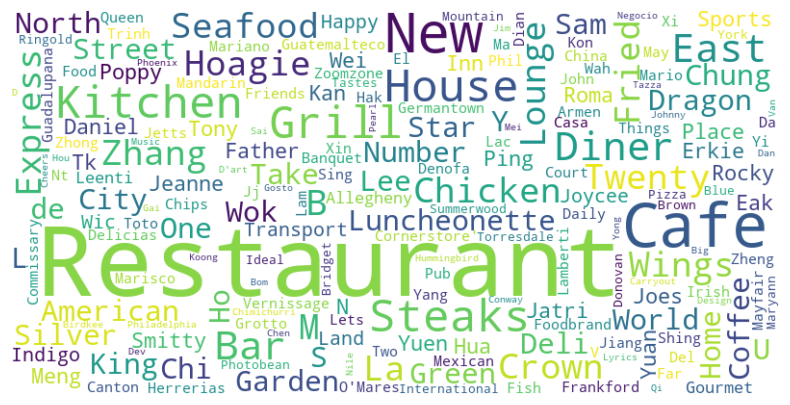

In [19]:
restaurant_cloud = food_desc[food_desc["desc_1"] == "restaurants"]

# Concatenate all text in the column
text = ' '.join(restaurant_cloud['name'].dropna())

# Create the word cloud
wordcloud = WordCloud(width=800, height=400, background_color ='white').generate(text)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [20]:
# Define the mapping
keyword_mapping = {
    'yuen': 'chinese',
    'ping': 'chinese',
    'zhong': 'chinese',
    'china': 'chinese',
    "chinese": "chinese",
    'canton': 'chinese',
    'wok': 'chinese',
    'lee': 'chinese',
    'china': 'chinese',
    'zhang': 'chinese',
    'chung': 'chinese',
    'dragon': 'chinese',
    'meng': 'chinese',
    'xin': 'chinese',
    'hua': 'chinese',
    'ping': 'chinese',
    'hua': 'chinese',
    'meng': 'chinese',
    'yi': 'chinese',
    'xi': 'chinese',
    'lam': 'chinese',
    'zhang': 'chinese',
    'wei': 'chinese',
    'salad': 'salad',
    'pizza': 'pizza',
    'grill': 'grill',
    "steak": "grill",
    'sushi': 'japanese',
    'chicken': 'chicken',
    'pizzeria': 'pizza',
    'pizza': 'pizza',
    'bbg': 'bbq',
    'hoagie': 'sandwich',
    'steaks': 'sandwich',
    'coffee': 'cafe', 
    'cafe': 'cafe',
    'diner': 'american',
    'luncheonette': 'american',
    'wings': 'wings',
    'deli': 'deli',
    'mexican': 'latin',
    'guadalupana': 'latin',
    'guatamelteco': 'latin',
    'fish': 'seafood',
    'casa': 'latin'}

# Function to find the keyword and return the corresponding desc_2 value
def map_keyword_to_desc(name, mapping):
    for keyword, desc in mapping.items():
        if re.search(re.escape(keyword), name, re.IGNORECASE):
            return desc
    return None

# Define the list of specific values
specific_values = ["food trucks", "fooddeliveryservices", "bars", "grocery", "restaurants"]

# Define the combined condition: desc_2 is NA or in the list of specific values
condition_combined = food_desc['desc_2'].isna() | food_desc['desc_1'].isin(specific_values)

# Apply the function to update desc_2 based on the combined condition
food_desc.loc[condition_combined, 'desc_1'] = food_desc.loc[condition_combined, 'name'].apply(lambda x: map_keyword_to_desc(x, keyword_mapping))

### Identify fast food/chain restaurants
Override desc_1 with "fastfood" for major chain restaurants.

In [21]:
food_desc.groupby("name").size().sort_values(ascending = False).head(10)

name
Wawa                         28
McDonald's                   25
Popeyes Louisiana Kitchen    19
Wendy's                      17
Philly Pretzel Factory       13
KFC                          13
Subway                       10
Wingstop                      9
Taco Bell                     9
Crown Fried Chicken           8
dtype: int64

In [22]:
fast_food = [
    "McDonald's",
    "Wawa", 
    "Wingstop",
    "MrBeast Burger",
    "Chick-fil-A",
    "Chipotle Mexican Grill",
    "Checkers",
    "Wendy's",
    "Subway",
    "Popeyes Louisiana Kitchen",
    "Taco Bell",
    "KFC",
    "Burger King",
]

In [23]:
food_desc.loc[food_desc["name"].isin(fast_food), "desc_1"] = "fastfood"

Take the descriptions with frequency < 6 and replace the string with the second term in alias

In [24]:
desc_counts = food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

# Filter for 'desc_1' values where count is less than 6
desc_less_than_six = desc_counts[desc_counts['count'] < 6]['desc_1']

# Convert the filtered results to a list
desc_list = desc_less_than_six.tolist()

# replace desc_1 with desc_2 where desc_1 is in the list of descriptions with frequency < 6
food_desc.loc[food_desc['desc_1'].isin(desc_list), 'desc_1'] = food_desc['desc_2']

In [25]:
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

,desc_1,count
83,pizza,327
29,chinese,179
47,fastfood,162
95,sandwiches,117
96,seafood,92
11,breakfast_brunch,81
38,deli,70
15,burgers,55
17,cafe,52
65,italian,42


In [26]:
food_cats = food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
top_food_cats = list(food_cats[food_cats["count"] >= 12]["desc_1"])
food_desc = food_desc[food_desc["desc_1"].isin(top_food_cats)]

### Sort into larger categories

In [27]:
# Define the mapping dictionary
desc_mapping = {
    "burgers": "sandwiches/delis",
    "hotdogs": "sandwiches/delis",
    "chicken_wings": "chicken",
    "tradamerican": "american",
    "newamerican": "american",
    "wings": "chicken",
    "hotdog": "diner/grill",
    "gastropubs": "diner/grill",
    "diners": "diner/grill",
    "steak": "diner/grill",
    "grills": "diner/grill",
    "grill": "diner/grill",
    "coffee": "bakeries/cafes",
    'cafe': "bakeries/cafes",
    "cafes": "bakeries/cafes",
    'bagels': "bakeries/cafes",
    'wraps': "bakeries/cafes",
    'soups': "bakeries/cafes",
    'soup': "bakeries/cafes",
    "cupcakes": "bakeries/cafes",
    "creperies": "bakeries/cafes",
    "bakeries": "bakeries/cafes",
    "juicebars": "bakeries/cafes",
    'donuts': "bakeries/cafes",
    'icecream': "bakeries/cafes",
    "ice cream": 'bakeries/cafes',
    "desserts": "bakeries/cafes",
    "waffles": "bakeries/cafes",
    "cakeshop": "bakeries/cafes",
    'customcakes': 'bakeries/cafes',
    "cheesesteaks": "sandwiches/delis",
    "sandwich": "sandwiches/delis",
    "sandwiches": "sandwiches/delis",
    "delis": "sandwiches/delis",
    "deli": "sandwiches/delis",
    "chickenshop": "chicken",
    "sushi": "japanese",
    "ramen": "japanese",
    'hotpot': 'chinese',
    "szechuan": "chinese",
    "cantonese": "chinese",
    "dimsum": "chinese",
    "shanghainese": "chinese",
    "pretzels": "bakeries/cafes",
    "mexican": "latin",
    "honduran": "latin",
    "nicaraguan": "latin",
    "spanish": "latin",
    "guatemalan": "latin",
    "tacos": "latin",
    "brazilian": "latin",
    "portuguese": "latin",
    "dominican": "caribbean",
    "haitian": "caribbean",
    "seafoodmarket,": "seafood",
    "seafoodmarkets,": "seafood",
    "greek": "mediterranean",
    "mideastern": "halal"
}

# Replace desc_1 values using the mapping dictionary
food_desc['desc_1'] = food_desc['desc_1'].replace(desc_mapping)

In [28]:
food_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

,desc_1,count
18,pizza,327
20,sandwiches/delis,301
2,bakeries/cafes,199
7,chinese,179
10,fastfood,162
21,seafood,92
4,breakfast_brunch,81
6,chicken,57
9,diner/grill,55
14,japanese,47


In [29]:
len(food_desc)

1858

## Parks

In [30]:
# Filter and create a copy to avoid SettingWithCopyWarning
parks_desc = parks.copy()

# Create a new column 'desc_1'
parks_desc["desc_1"] = parks_desc['alias'].str.split(',').str[0].str.strip().str.lower()
parks_desc["desc_2"] = parks_desc['alias'].str.split(',').str[1].str.strip().str.lower()
parks_desc["desc_3"] = parks_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### First word in 'alias'

In [31]:
# Group by 'desc_1' and count, then convert to DataFrame
parks_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(100)

,desc_1,count
19,parks,150
15,landmarks,36
21,playgrounds,25
7,dog_parks,23
13,hiking,17
24,recreation,9
12,gardens,7
25,skate_parks,6
28,tennis,4
11,football,4


### Filter for categories where frequency ≥ 5

In [32]:
park_desc_1 = parks_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(9)
top_park_desc = list(park_desc_1["desc_1"])
# remove historical landmarks
top_park_desc.remove('landmarks')

# filter for obs in the list of top descriptions
parks_desc = parks_desc[parks_desc["desc_1"].isin(top_park_desc)]
parks_desc.head(10)

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Cedar Park,4.5,50th St & Baltimore Ave,parks,Parks,POINT (2677006.643 234133.514),parks,NaN,NaN
1,Chester Avenue Dog Park,3.5,801 S 48th St,dog_parks,Dog Parks,POINT (2678024.964 234174.704),dog_parks,NaN,NaN
2,Malcolm X Park,4.0,51ST And Pine St,parks,Parks,POINT (2676187.013 235721.062),parks,NaN,NaN
3,Barkan Park,3.0,4936 Spruce St,"parks, playgrounds","Parks, Playgrounds",POINT (2677109.530 236278.545),parks,playgrounds,NaN
4,Clark Park Dog Bowl,4.5,43rd & Chester,dog_parks,Dog Parks,POINT (2680815.785 234312.734),dog_parks,NaN,NaN
5,Clark Park,4.5,43RD And Baltimore,parks,Parks,POINT (2680756.007 234729.865),parks,NaN,NaN
6,Greys Ferry Cresent Skatepark,5.0,3600 Grays Ferry Ave,skate_parks,Skate Parks,POINT (2683004.637 231400.562),skate_parks,NaN,NaN
7,Grays Ferry Crescent,4.0,,parks,Parks,POINT (2682813.782 232182.835),parks,NaN,NaN
8,Lanier Dog Park,4.0,2911 Tasker St,dog_parks,Dog Parks,POINT (2685221.027 229056.524),dog_parks,NaN,NaN
9,Saunder's Green,3.5,300-50 Saunders Ave,parks,Parks,POINT (2683400.920 238616.685),parks,NaN,NaN


## Education

In [33]:
# Filter and create a copy to avoid SettingWithCopyWarning
edu_desc = education.copy()

# Create a new column 'desc_1'
edu_desc["desc_1"] = edu_desc['alias'].str.split(',').str[0].str.strip().str.lower()
edu_desc["desc_2"] = edu_desc['alias'].str.split(',').str[1].str.strip().str.lower()
edu_desc["desc_3"] = edu_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### First word in alias

In [34]:
# Group by 'desc_1' and count, then convert to DataFrame
edu_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

,desc_1,count
14,childcare,91
29,elementaryschools,86
66,preschools,62
17,collegeuniv,55
43,highschools,33
26,driving_schools,31
28,educationservices,25
75,specialtyschools,23
81,theater,17
6,artschools,15


### Filter for frequency ≥ 6

In [35]:
edu_desc_1 = edu_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(18)
top_edu_desc = list(edu_desc_1["desc_1"])
# remove historical landmarks
top_edu_desc.remove('theater')

# filter for obs in the list of top descriptions
edu_desc_1 = edu_desc[edu_desc["desc_1"].isin(top_edu_desc)]
edu_desc.head(10)

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,BellyWise,5.0,NaN,"midwives, specialtyschools","Midwives, Specialty Schools",POINT (2676169.939 231988.984),midwives,specialtyschools,NaN
1,Limitless CPR,5.0,NaN,cprclasses,CPR Classes,POINT (2677042.522 231394.414),cprclasses,NaN,NaN
2,Michele Judge,5.0,4919 Pentridge St,"jewelryrepair, artclasses, jewelry","Jewelry Repair, Art Classes, Jewelry",POINT (2677304.635 233898.273),jewelryrepair,artclasses,jewelry
3,Kipp West Philadelphia Prep Charter,1.0,5900 Baltimore Ave,specialed,Special Education,POINT (2671666.162 232636.864),specialed,NaN,NaN
4,Beulah Baptist Christian Day School,2.0,5001 Spruce St,"elementaryschools, preschools","Elementary Schools, Preschools",POINT (2677065.563 236331.076),elementaryschools,preschools,NaN
5,The Academy of Industrial Arts,5.0,6328 Paschall Ave,"vocation, electricians","Vocational & Technical School, Electricians",POINT (2674851.743 225884.662),vocation,electricians,NaN
6,TYLII,3.0,5124 Walnut St,"preschools, childcare","Preschools, Child Care & Day Care",POINT (2676415.568 237130.841),preschools,childcare,NaN
7,University of the Sciences,3.0,600 S 43rd St,collegeuniv,Colleges & Universities,POINT (2681062.408 233555.127),collegeuniv,NaN,NaN
8,All Around This World,5.0,4336 Pine St,educationservices,Educational Services,POINT (2680347.395 235381.376),educationservices,NaN,NaN
9,Jubilee School,3.0,4211 Chester Ave,highschools,Middle Schools & High Schools,POINT (2681043.809 234475.721),highschools,NaN,NaN


## Grocery

In [36]:
# Filter and create a copy to avoid SettingWithCopyWarning
grocery_desc = grocery.copy()

# Create a new column 'desc_1'
grocery_desc["desc_1"] = grocery_desc['alias'].str.split(',').str[0].str.strip().str.lower()
grocery_desc["desc_2"] = grocery_desc['alias'].str.split(',').str[1].str.strip().str.lower()
grocery_desc["desc_3"] = grocery_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [37]:
grocery_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Kim A Grocery & Deli,1.0,1840 S 58th St,grocery,Grocery,POINT (2675396.135 229529.164),grocery,NaN,NaN
1,S and J Seafood,4.0,713 S 52nd St,"seafoodmarkets, grocery","Seafood Markets, Grocery",POINT (2675793.250 234207.384),seafoodmarkets,grocery,NaN
2,Mariposa Food Co-op,4.0,4824 Baltimore Ave,"grocery, healthmarkets","Grocery, Health Markets",POINT (2677563.153 234052.277),grocery,healthmarkets,NaN
3,Jennifer Grocery,2.5,4824 Chester Ave,"grocery, convenience","Grocery, Convenience Stores",POINT (2678754.671 232771.760),grocery,convenience,NaN
4,Fu-Wah Mini Market,4.5,810 S 47th St,"convenience, sandwiches, grocery","Convenience Stores, Sandwiches, Grocery",POINT (2678571.989 234207.924),convenience,sandwiches,grocery


## Nightlife

In [38]:
# Filter and create a copy to avoid SettingWithCopyWarning
night_desc = nightlife.copy()

# Create a new column 'desc_1'
night_desc["desc_1"] = night_desc['alias'].str.split(',').str[0].str.strip().str.lower()
night_desc["desc_2"] = night_desc['alias'].str.split(',').str[1].str.strip().str.lower()
night_desc["desc_3"] = night_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [39]:
night_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Pentridge Station Beer Garden,4.5,5116 Pentridge St,beergardens,Beer Gardens,POINT (2676581.781 233167.788),beergardens,NaN,NaN
1,720 Bistro,4.0,720 S.52nd st,"seafood, breakfast_brunch, cocktailbars","Seafood, Breakfast & Brunch, Cocktail Bars",POINT (2675620.054 234102.746),seafood,breakfast_brunch,cocktailbars
2,Bayou,4.5,5025 Baltimore Ave,lounges,Lounges,POINT (2676525.799 234061.840),lounges,NaN,NaN
3,Booker's Restaurant and Bar,3.5,5021 Baltimore Ave,"bars, breakfast_brunch, tradamerican","Bars, Breakfast & Brunch, American",POINT (2676559.222 234070.085),bars,breakfast_brunch,tradamerican
4,The Wine Garden,4.5,5019 Baltimore Ave,wine_bars,Wine Bars,POINT (2676563.551 234060.148),wine_bars,NaN,NaN


### Alias

In [40]:
# Group by 'desc_1' and count, then convert to DataFrame
night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
6,bars,172
86,sportsbars,78
75,pubs,71
34,divebars,53
61,lounges,49
100,tradamerican,49
67,newamerican,47
23,cocktailbars,39
47,hookah_bars,28
66,musicvenues,28


In [41]:
# Group by 'desc_2' and count, then convert to DataFrame
night_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_2,count
7,bars,93
103,tradamerican,61
93,sportsbars,48
25,cocktailbars,43
69,newamerican,39
62,lounges,28
86,seafood,28
68,musicvenues,25
80,pubs,24
11,beerbar,19


In [42]:
# Group by 'desc_3' and count, then convert to DataFrame
night_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_3,count
17,cocktailbars,51
70,tradamerican,39
3,bars,24
8,breakfast_brunch,21
6,beerbar,20
72,venues,17
10,burgers,17
56,sandwiches,15
48,musicvenues,12
62,sportsbars,12


### Replace desc_1 with more relevant alias terms

In [43]:
# replace desc_2
condition1 = night_desc['desc_2'].isin(["newamerican", "seafood", "breakfast_brunch", "tradamerican", "burgers", "sandwiches", "pizza", "mexican", "italian",
                                       "french", "ramen", "tapasmallplates", "french", "ramen", "mideastern", "comfortfood", "steak", "mediterranean", "caribbean",
                                       "bbq", "peruvian", "japanese", "ethiopian", "tex-mex", "southern", "juicebars", "cajun", "soulfood", "portugeuse", "sushi",
                                       "vegan", "cafes", "diners", "chicken-wings", "chinese", "salad", "cheesesteaks", "african", "german", "desserts", "indpak",
                                       "thai", "tacos", "falafel", "vietnamese", "waffles", "delis", "coffee", "korean", "hotdog", "moroccan", "newmexican", "cuban",
                                       "argentine", "gluten_free", "russian", "bakeries", "portuguese", "spanish", "latin", "catering", "gastropubs", 
                                       "breweries", "gaybars", "whiskeybars", "tikibars", "tobaccoshops", "beer_and_wine", "breweries", "venues",
                                       "poolhalls", "jazzandblues", "airportlounges", "cigarbars", "speakeasies", "theater", "nightlife"])

condition2 = night_desc['desc_3'].notna()

# Update desc_1 where conditions are met
night_desc.loc[condition1 & condition2, 'desc_2'] = night_desc['desc_3']


# replace desc_1
condition1 = night_desc['desc_1'].isin(["newamerican", "seafood", "breakfast_brunch", "tradamerican", "burgers", "sandwiches", "pizza", "mexican", "italian",
                                       "french", "ramen", "tapasmallplates", "french", "ramen", "mideastern", "comfortfood", "steak", "mediterranean", "caribbean",
                                       "bbq", "peruvian", "japanese", "ethiopian", "tex-mex", "southern", "juicebars", "cajun", "soulfood", "portugeuse", "sushi",
                                       "vegan", "cafes", "diners", "chicken-wings", "chinese", "salad", "cheesesteaks", "african", "german", "desserts", "indpak",
                                       "thai", "tacos", "falafel", "vietnamese", "waffles", "delis", "coffee", "korean", "hotdog", "moroccan", "newmexican", "cuban",
                                       "argentine", "gluten_free", "russian", "bakeries", "portuguese", "spanish", "latin", "catering", "gastropubs", 
                                       "breweries", "gaybars", "whiskeybars", "tikibars", "tobaccoshops", "beer_and_wine", "breweries", "venues",
                                       "poolhalls", "jazzandblues", "airportlounges", "cigarbars", "speakeasies", "theater", "nightlife"])

condition2 = night_desc['desc_2'].notna()

# Update desc_1 where conditions are met
night_desc.loc[condition1 & condition2, 'desc_1'] = night_desc['desc_2']

night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(15)

,desc_1,count
4,bars,271
51,sportsbars,114
12,cocktailbars,105
45,pubs,86
39,lounges,64
20,divebars,60
6,beerbar,44
61,wine_bars,42
40,musicvenues,42
31,hookah_bars,36


### Filter for categories where frequency ≥ 8

In [44]:
night_desc_1 = night_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(9)
top_night_desc = list(night_desc_1["desc_1"])

# filter for obs in the list of top descriptions
night_desc = night_desc[night_desc["desc_1"].isin(top_night_desc)]
night_desc.head(10)

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
1,720 Bistro,4.0,720 S.52nd st,"seafood, breakfast_brunch, cocktailbars","Seafood, Breakfast & Brunch, Cocktail Bars",POINT (2675620.054 234102.746),cocktailbars,cocktailbars,cocktailbars
2,Bayou,4.5,5025 Baltimore Ave,lounges,Lounges,POINT (2676525.799 234061.840),lounges,NaN,NaN
3,Booker's Restaurant and Bar,3.5,5021 Baltimore Ave,"bars, breakfast_brunch, tradamerican","Bars, Breakfast & Brunch, American",POINT (2676559.222 234070.085),bars,tradamerican,tradamerican
4,The Wine Garden,4.5,5019 Baltimore Ave,wine_bars,Wine Bars,POINT (2676563.551 234060.148),wine_bars,NaN,NaN
5,Carbon Copy,4.5,701 S 50th St,"breweries, pizza, bars","Breweries, Pizza, Bars",POINT (2676997.957 233927.765),bars,bars,bars
6,Dock Street Cannery and Tasting Room,4.0,705 S 50th St,"beerbar, lounges","Beer Bar, Lounges",POINT (2677046.168 233912.738),beerbar,lounges,NaN
7,Trendsetters Bar & Lounge,3.5,5301 Woodland Ave,"burgers, lounges, wraps","Burgers, Lounges, Wraps",POINT (2678439.957 230236.502),lounges,lounges,wraps
8,The Barn,3.5,4901 Catharine St,"poolhalls, sportsbars, divebars","Pool Halls, Sports Bars, Dive Bars",POINT (2677365.738 234212.623),sportsbars,sportsbars,divebars
9,Eris Temple,4.0,602 S 52nd St,musicvenues,Music Venues,POINT (2675702.055 234852.608),musicvenues,NaN,NaN
10,Dahlak,3.5,4708 Baltimore Ave,"ethiopian, divebars","Ethiopian, Dive Bars",POINT (2678487.076 234234.642),divebars,divebars,NaN


## Entertainment

In [45]:
# Filter and create a copy to avoid SettingWithCopyWarning
entertain_desc = entertainment.copy()

# Create a new column 'desc_1'
entertain_desc["desc_1"] = entertain_desc['alias'].str.split(',').str[0].str.strip().str.lower()
entertain_desc["desc_2"] = entertain_desc['alias'].str.split(',').str[1].str.strip().str.lower()
entertain_desc["desc_3"] = entertain_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [46]:
entertain_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Noam Osband,5.0,NaN,musicians,Musicians,POINT (2676083.283 232370.886),musicians,NaN,NaN
1,Ceramic Concept,5.0,5015 Baltimore Ave,galleries,Art Galleries,POINT (2676620.711 234054.592),galleries,NaN,NaN
2,Eris Temple,4.0,602 S 52nd St,musicvenues,Music Venues,POINT (2675702.055 234852.608),musicvenues,NaN,NaN
3,Baltimore Avenue Dollar Stroll,5.0,4800 Baltimore Ave,"unofficialyelpevents, festivals","Unofficial Yelp Events, Festivals",POINT (2677842.004 234135.971),unofficialyelpevents,festivals,NaN
4,Curio Theatre Company,4.5,815 S 48th St,theater,Performing Arts,POINT (2678192.432 234160.959),theater,NaN,NaN


### Alias

In [47]:
# Group by 'desc_1' and count, then convert to DataFrame
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
130,theater,127
53,galleries,96
50,festivals,69
86,museums,42
42,djs,28
89,musicvenues,28
105,psychics,23
85,movietheaters,20
117,social_clubs,19
47,eventplanning,16


In [48]:
entertain_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_2,count
45,galleries,32
80,musicvenues,25
116,theater,24
119,venues,19
35,dancestudio,14
39,eventplanning,11
34,danceclubs,10
75,movietheaters,10
4,arcades,9
14,bars,8


In [49]:
entertain_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_3,count
59,musicvenues,13
92,venues,9
25,dance_schools,6
27,dancestudio,5
58,musicians,5
34,eventplanning,5
49,kids_activities,5
2,arcades,4
3,artclasses,4
89,theater,4


### Replace desc_1 with more relevant alias terms

In [50]:
# replace desc_2
condition1 = entertain_desc['desc_2'].isin(["arts", "musicians", "kids_activities", "venues", "bars", "nonprofit", "lounges"])

condition2 = entertain_desc['desc_3'].notna()

# Update desc_1 where conditions are met
entertain_desc.loc[condition1 & condition2, 'desc_2'] = entertain_desc['desc_3']


# replace desc_1
condition1 = entertain_desc['desc_1'].isin(["arts", "musicians", "kids_activities", "venues", "bars", "nonprofit", "lounges"])

condition2 = entertain_desc['desc_2'].notna()

# Update desc_1 where conditions are met
entertain_desc.loc[condition1 & condition2, 'desc_1'] = entertain_desc['desc_2']

entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(40)

,desc_1,count
131,theater,130
55,galleries,98
52,festivals,70
87,museums,42
90,musicvenues,34
43,djs,29
118,social_clubs,24
106,psychics,23
86,movietheaters,21
48,eventplanning,17


### Filter for frequency 

In [51]:
entertain_desc_1 = entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
entertain_desc_1 = entertain_desc_1[entertain_desc_1['count'] >= 5]

top_entertain_desc = list(entertain_desc_1["desc_1"])


top_entertain_desc.remove('psychics')

# filter for obs in the list of top descriptions
entertain_desc = entertain_desc[entertain_desc["desc_1"].isin(top_entertain_desc)]

In [52]:
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

,desc_1,count
31,theater,130
16,galleries,98
15,festivals,70
21,museums,42
22,musicvenues,34
13,djs,29
28,social_clubs,24
20,movietheaters,21
14,eventplanning,17
11,danceclubs,16


In [53]:
# Define the mapping dictionary
desc_mapping = {
    "djs": "nightclubs",
    "danceclubs": "nightclubs",
    "artmuseums": "museums",
    "sportsteams": "sports",
    "stadiumsarenas": "sports",
    "paintandsip": "specialtyclasses",
    "dancestudio": "specialtyclasses",
    "bowling": "games/arcade",
    "bingo": "games/arcade",
    "arcades": "games/arcade",
    "artclasses": "specialtyclasses"
}

# Replace desc_1 values using the mapping dictionary
entertain_desc.loc[:, 'desc_1'] = entertain_desc['desc_1'].replace(desc_mapping)

In [54]:
entertain_cat = entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)
entertain_cat_top = list(entertain_cat[entertain_cat["count"] >= 11]["desc_1"])
# filter for desc_1
entertain_desc = entertain_desc[entertain_desc["desc_1"].isin(entertain_cat_top)]
entertain_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

,desc_1,count
12,theater,130
3,galleries,98
2,festivals,70
6,museums,52
8,nightclubs,45
7,musicvenues,34
10,specialtyclasses,25
9,social_clubs,24
4,games/arcade,21
5,movietheaters,21


## Shopping

In [55]:
# Filter and create a copy to avoid SettingWithCopyWarning
shop_desc = shopping.copy()

# Create a new column 'desc_1'
shop_desc["desc_1"] = shop_desc['alias'].str.split(',').str[0].str.strip().str.lower()
shop_desc["desc_2"] = shop_desc['alias'].str.split(',').str[1].str.strip().str.lower()
shop_desc["desc_3"] = shop_desc['alias'].str.split(',').str[2].str.strip().str.lower()

In [56]:
shop_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Rite Aid,2.0,5214-30 Baltimore Ave,"drugstores, convenience","Drugstores, Convenience Stores",POINT (2675264.630 233732.096),drugstores,convenience,NaN
1,Ajah Creative Sweets And Treats & More,5.0,NaN,"desserts, cupcakes, giftshops","Desserts, Cupcakes, Gift Shops",POINT (2677939.712 232732.831),desserts,cupcakes,giftshops
2,Ceramic Concept,5.0,5015 Baltimore Ave,galleries,Art Galleries,POINT (2676620.711 234054.592),galleries,NaN,NaN
3,VIX Emporium,4.5,5009 Baltimore Ave,"artsandcrafts, childcloth, jewelry","Arts & Crafts, Children's Clothing, Jewelry",POINT (2676676.410 234091.659),artsandcrafts,childcloth,jewelry
4,Michele Judge,5.0,4919 Pentridge St,"jewelryrepair, artclasses, jewelry","Jewelry Repair, Art Classes, Jewelry",POINT (2677304.635 233898.273),jewelryrepair,artclasses,jewelry


### Alias

In [57]:
# Group by 'desc_1' and count, then convert to DataFrame
shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
32,drugstores,234
142,womenscloth,114
69,jewelry,90
31,discountstore,87
49,galleries,84
48,furniture,74
113,shoes,68
29,deptstores,56
86,menscloth,50
11,bookstores,41


In [58]:
# Group by 'desc_2' and count, then convert to DataFrame
shop_desc.groupby("desc_2").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_2,count
24,convenience,95
0,accessories,67
139,womenscloth,66
81,menscloth,51
48,furniture,38
65,jewelry,35
100,pharmacy,34
35,discountstore,32
49,galleries,29
61,homedecor,27


In [59]:
# Group by desc_3' and count, then convert to DataFrame
shop_desc.groupby("desc_3").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_3,count
21,convenience,55
0,accessories,30
115,womenscloth,28
54,homedecor,26
79,pharmacy,23
95,sportswear,18
92,shoes,18
56,jewelry,18
15,childcloth,16
108,vintage,15


### Filter for most common labels

In [60]:
shop_desc_1 = shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_shop_desc = list(shop_desc_1["desc_1"])
top_shop_desc

['drugstores',
 'womenscloth',
 'jewelry',
 'discountstore',
 'galleries',
 'furniture',
 'shoes',
 'deptstores',
 'menscloth',
 'bookstores',
 'accessories',
 'thrift_stores',
 'antiques',
 'grocery',
 'giftshops',
 'homedecor',
 'selfstorage',
 'childcloth',
 'sportswear',
 'vintage']

In [61]:
# remove drugstores and grocery
top_shop_desc.remove('drugstores')
top_shop_desc.remove('grocery')

# filter for obs in the list of top descriptions
shop_desc = shop_desc[shop_desc["desc_1"].isin(top_shop_desc)]

In [62]:
# Define the mapping dictionary
desc_mapping = {
    "mattresses": "furniture",
    "kitchenandbath": "furniture",
    "rugs": "homedecor",
    "hats": "accessories",
    "watch_repair": "accessories"
}

# Replace desc_1 values using the mapping dictionary
shop_desc.loc[:, 'desc_1'] = shop_desc['desc_1'].replace(desc_mapping)
shop_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

,desc_1,count
17,womenscloth,114
10,jewelry,90
5,discountstore,87
7,galleries,84
6,furniture,74
13,shoes,68
4,deptstores,56
11,menscloth,50
2,bookstores,41
0,accessories,40


## Healthcare

In [63]:
# Filter and create a copy to avoid SettingWithCopyWarning
health_desc = healthcare.copy()

# Create a new column 'desc_1'
health_desc["desc_1"] = health_desc['alias'].str.split(',').str[0].str.strip().str.lower()
health_desc["desc_2"] = health_desc['alias'].str.split(',').str[1].str.strip().str.lower()
health_desc["desc_3"] = health_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### Alias

In [64]:
# Group by 'desc_1' and count, then convert to DataFrame
health_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
38,laboratorytesting,33
80,urgent_care,26
33,homehealthcare,25
43,medcenters,23
29,generaldentistry,21
35,hospitals,20
37,internalmed,19
21,drugstores,19
26,familydr,16
11,chiropractors,14


### Filter for most common labels

In [65]:
health_desc_1 = health_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_health_desc = list(shop_desc_1["desc_1"])
top_health_desc

['drugstores',
 'womenscloth',
 'jewelry',
 'discountstore',
 'galleries',
 'furniture',
 'shoes',
 'deptstores',
 'menscloth',
 'bookstores',
 'accessories',
 'thrift_stores',
 'antiques',
 'grocery',
 'giftshops',
 'homedecor',
 'selfstorage',
 'childcloth',
 'sportswear',
 'vintage']

In [66]:
# filter for obs in the list of top descriptions
health_desc = health_desc[health_desc["desc_1"].isin(top_health_desc)]

## Historic landmarks

In [67]:
# Filter and create a copy to avoid SettingWithCopyWarning
historic_desc = historic.copy()

# Create a new column 'desc_1'
historic_desc["desc_1"] = historic_desc['alias'].str.split(',').str[0].str.strip().str.lower()
historic_desc["desc_2"] = historic_desc['alias'].str.split(',').str[1].str.strip().str.lower()
historic_desc["desc_3"] = historic_desc['alias'].str.split(',').str[2].str.strip().str.lower()

### Alias

In [68]:
# Group by 'desc_1' and count, then convert to DataFrame
historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
1,landmarks,46
4,museums,25
0,artmuseums,2
2,libraries,2
9,venues,2
3,municipality,1
5,nonprofit,1
6,postoffices,1
7,publicart,1
8,religiousorgs,1


### Filter for most common labels

In [69]:
historic_desc_1 = historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(3)
top_historic_desc = list(historic_desc_1["desc_1"])
top_historic_desc

['landmarks', 'museums', 'artmuseums']

In [70]:
# filter for obs in the list of top descriptions
historic_desc = historic_desc[historic_desc["desc_1"].isin(top_historic_desc)]

In [71]:
# Define the mapping dictionary
desc_mapping = {
    "artmuseums": "museums"
}

# Replace desc_1 values using the mapping dictionary
historic_desc['desc_1'] = historic_desc['desc_1'].replace(desc_mapping)
historic_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

,desc_1,count
0,landmarks,46
1,museums,27


## Kids activities

In [72]:
kids_desc = kids.copy()

# Create a new column 'desc_1'
kids_desc["desc_1"] = kids_desc['alias'].str.split(',').str[0].str.strip().str.lower()
kids_desc["desc_2"] = kids_desc['alias'].str.split(',').str[1].str.strip().str.lower()
kids_desc["desc_3"] = kids_desc['alias'].str.split(',').str[2].str.strip().str.lower()

kids_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Makono African Hair Braiding,3.0,5529 Baltimore Ave,"hairstylists, cosmetics","Hair Stylists, Cosmetics & Beauty Supply",POINT (2673677.520 233714.490),hairstylists,cosmetics,NaN
1,Carbon Copy,4.5,701 S 50th St,"breweries, pizza, bars","Breweries, Pizza, Bars",POINT (2676997.957 233927.765),breweries,pizza,bars
2,Firehouse Bicycles,4.5,701 S 50th St,"bikes, bike_repair_maintenance","Bikes, Bike Repair/Maintenance",POINT (2677005.367 233951.502),bikes,bike_repair_maintenance,NaN
3,Common Beat Music,4.0,4916 Baltimore Ave,"vinyl_records, electronicsrepair, musicinstrumentservices","Vinyl Records, Electronics Repair, Musical Instrument Services",POINT (2677188.738 233998.088),vinyl_records,electronicsrepair,musicinstrumentservices
4,Cedar Park,4.5,50th St & Baltimore Ave,parks,Parks,POINT (2677006.643 234133.514),parks,NaN,NaN


### Alias

In [73]:
# Group by 'desc_1' and count, then convert to DataFrame
kids_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
45,childcare,92
232,parks,53
131,generaldentistry,39
87,drugstores,36
141,gyms,34
255,preschools,29
311,theater,26
95,elementaryschools,26
189,libraries,26
107,festivals,25


In [74]:
kids_desc = kids_desc[kids_desc["desc_1"].isin(["childcare", "parks", "preschools", "theater", "libraries", "festivals", "museums", 
                                                "martialarts", "churches", "playgrounds", "musicalinstrumentsandteachers", "landmarks", 
                                                "kids_activities"])]

In [75]:
kids_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False)

,desc_1,count
0,childcare,92
9,parks,53
11,preschools,29
5,libraries,26
12,theater,26
2,festivals,25
7,museums,19
1,churches,18
6,martialarts,18
10,playgrounds,18


## Art and music

In [76]:
arts_desc = arts.copy()

# Create a new column 'desc_1'
arts_desc["desc_1"] = arts_desc['alias'].str.split(',').str[0].str.strip().str.lower()
arts_desc["desc_2"] = arts_desc['alias'].str.split(',').str[1].str.strip().str.lower()
arts_desc["desc_3"] = arts_desc['alias'].str.split(',').str[2].str.strip().str.lower()

arts_desc.head()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
0,Curio Theatre Company,4.5,815 S 48th St,theater,Performing Arts,POINT (2678192.432 234160.959),theater,NaN,NaN
1,Studio 34,4.5,4522 Baltimore Ave,"yoga, pilates, theater","Yoga, Pilates, Performing Arts",POINT (2679553.196 234477.061),yoga,pilates,theater
2,Painted Bride Art Center,3.5,5212 Market St,"theater, venues","Performing Arts, Venues & Event Spaces",POINT (2676029.704 238278.040),theater,venues,NaN
3,The Rotunda,4.5,4014 Walnut St,"musicvenues, theater","Music Venues, Performing Arts",POINT (2682266.656 236480.866),musicvenues,theater,NaN
4,Penn Live Arts,4.0,3680 Walnut St,"theater, jazzandblues, musicvenues","Performing Arts, Jazz & Blues, Music Venues",POINT (2684326.329 236037.832),theater,jazzandblues,musicvenues


### Alias

In [77]:
# Group by 'desc_1' and count, then convert to DataFrame
arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
27,theater,163
7,dancestudio,11
18,musicalinstrumentsandteachers,11
12,galleries,9
20,musicvenues,6
19,musicians,5
11,festivals,5
6,dance_schools,5
3,artschools,4
1,artmuseums,4


### Regroup into large categories

In [78]:
# Define the mapping dictionary
desc_mapping = {
    "specialtyschools": "classes",
    "dance_schools": "classes",
    "artschools": "classes",
    "musicalinstrumentsandteachers": "classes",
    "dancestudio": "dancestudios",
    "galleries": "gallery/museum",
    "museums": "gallery/museum",
    "artmuseums": "gallery/museum",
    "festivals": "events/shows",
    "jazzandblues": "events/shows",
    "djs": "events/shows",
    "musicvenues": "events/shows",
    "comedyclubs": "events/shows",
    "magicians": "events/shows",
    "musicians": "events/shows"
}

# Replace desc_1 values using the mapping dictionary
arts_desc['desc_1'] =arts_desc['desc_1'].replace(desc_mapping)
arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)

,desc_1,count
16,theater,163
7,events/shows,24
2,classes,22
8,gallery/museum,15
4,dancestudios,11
3,culturalcenter,2
0,aerialfitness,1
12,opera,1
17,venues,1
15,summer_camps,1


### Filter for most common labels

In [79]:
arts_desc_1 = arts_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(20)
top_arts_desc = list(arts_desc_1["desc_1"])

# remove historical landmarks
top_arts_desc.remove('summer_camps')
top_arts_desc.remove('preschools')
top_arts_desc.remove('language_schools')
top_arts_desc.remove('educationservices')

top_arts_desc

['theater',
 'events/shows',
 'classes',
 'gallery/museum',
 'dancestudios',
 'culturalcenter',
 'aerialfitness',
 'opera',
 'venues',
 'social_clubs',
 'hair',
 'nonprofit',
 'arts',
 'dinnertheater',
 'yoga']

In [80]:
arts_desc = arts_desc[arts_desc["desc_1"].isin(top_arts_desc)]

## Beauty

In [81]:
beauty_desc = beauty.copy()

# Create a new column 'desc_1'
beauty_desc["desc_1"] = beauty_desc['alias'].str.split(',').str[0].str.strip().str.lower()
beauty_desc["desc_2"] = beauty_desc['alias'].str.split(',').str[1].str.strip().str.lower()
beauty_desc["desc_3"] = beauty_desc['alias'].str.split(',').str[2].str.strip().str.lower()

beauty_desc.tail()

,name,rating,address,alias,title,geometry,desc_1,desc_2,desc_3
2156,Lips and Drips by Erica Marie,5.0,2342 S Broad St,"medicalspa, ivhydration","Medical Spas, IV Hydration",POINT (2691839.535 224599.252),medicalspa,ivhydration,NaN
2157,The Lash Lounge Wyndmoor - 909 Willow,4.0,909 E Willow Grove Ave,"eyelashservice, eyebrowservices, threadingservices","Eyelash Service, Eyebrow Services, Threading Services",POINT (2685044.968 283383.097),eyelashservice,eyebrowservices,threadingservices
2158,Hair Expo,3.5,7721 Crittenden St,hairstylists,Hair Stylists,POINT (2683447.588 279731.355),hairstylists,NaN,NaN
2159,The Cut Bar,4.0,532 S 4th St,barbers,Barbers,POINT (2697625.976 232400.348),barbers,NaN,NaN
2160,House of Hair Lounge,3.0,259 S 60th St,hairstylists,Hair Stylists,POINT (2671622.181 237231.748),hairstylists,NaN,NaN


In [82]:
# Group by 'desc_1' and count, then convert to DataFrame
beauty_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending = False).head(10)

,desc_1,count
85,hair,378
146,othersalons,342
12,barbers,149
89,hairstylists,87
43,cosmetics,82
119,massage,74
70,florists,53
117,makeupartists,49
86,hair_extensions,35
188,tattoo,33


In [83]:
remove_cat = ["florists", "jewelry", "drugstores", "generaldentistry", "discountstore", "womenscloth", 
              "deptstores", "furniture", "", "bookstores", "galleries", "giftshops", "artsandcrafts", 
              "gardening", "fabricstores", "antiques", "menscloth", "orthodontists", "vintage", 
              "thriftstores", "stationary", "bikes", "beautysvc", "accessories", "optometrists", 
              "framing", "interiordesign", "tobaccoshops", "homedecor", "stationary", "thriftstores"]

# Grouping, counting, and filtering beauty_desc
beauty_desc_1 = beauty_desc.groupby("desc_1").size().reset_index(name='count').sort_values("count", ascending=False)
top_beauty_desc = beauty_desc_1[beauty_desc_1['count'] > 6]

# Filtering top_beauty_desc to remove unwanted categories
top_beauty_desc = top_beauty_desc[~top_beauty_desc["desc_1"].isin(remove_cat)]["desc_1"]

beauty_desc = beauty_desc[beauty_desc["desc_1"].isin(top_beauty_desc)]

# Combine all amenities

In [84]:
# Create explicit copies of the DataFrame slices
food_desc = food_desc.copy()
parks_desc = parks_desc.copy()
edu_desc = edu_desc.copy()
grocery_desc = grocery_desc.copy()
entertain_desc = entertain_desc.copy()
night_desc = night_desc.copy()
shop_desc = shop_desc.copy()
health_desc = health_desc.copy()
historic_desc = historic_desc.copy()
arts_desc = arts_desc.copy()
beauty_desc = beauty_desc.copy()
kids_desc = kids_desc.copy()

# Now perform the operations
food_desc.loc[:, 'type'] = 'restaurant'
parks_desc.loc[:, 'type'] = 'parks'
edu_desc.loc[:, 'type'] = 'education'
grocery_desc.loc[:, 'type'] = 'grocery'
entertain_desc.loc[:, 'type'] = 'entertainment'
night_desc.loc[:, 'type'] = 'nightlife'
shop_desc.loc[:, 'type'] = 'shopping'
health_desc.loc[:, 'type'] = 'healthcare'
historic_desc.loc[:, 'type'] = 'historic'
arts_desc.loc[:, 'type'] = 'arts'
beauty_desc.loc[:, 'type'] = 'beauty'
kids_desc.loc[:, 'type'] = 'kids'

In [85]:
# combine gdfs
amenities = gpd.GeoDataFrame(pd.concat([food_desc, parks_desc, edu_desc, grocery_desc, entertain_desc, night_desc, shop_desc,
                                       health_desc, historic_desc, arts_desc, beauty_desc, kids_desc], ignore_index=True))

## Clip to Philly bounds

In [135]:
phl_bound_squeezed = phl_bound_proj.squeeze().geometry

amenities_phl = amenities.within(phl_bound_squeezed)
amenities_phl_gdf = amenities[amenities_phl]

In [91]:
# count by type
amenities_grouped = amenities_phl_gdf.groupby('type').size().reset_index(name='count')

In [92]:
amenities_grouped.to_csv('amenities_grouped.csv', index=False)
amenities_phl_gdf.to_file('amenities_phl_gdf.geojson', driver='GeoJSON', index=False)

In [113]:
amenities_tract.to_file('amenities_tract.geojson', driver='GeoJSON', index=False)

## Intersect with neighborhoods

In [95]:
amenities_neighborhood = gpd.sjoin(amenities_phl_gdf, neigh, how = "left", predicate = "intersects")
amenities_tract = gpd.sjoin(amenities_phl_gdf, tract, how = "left", predicate = "intersects")

In [116]:
amenities_neigh_group = amenities_neighborhood.groupby(["nb_name", "type"]).size().reset_index(name='count')
amenities_tract_group = amenities_tract.groupby(["nb_name", "type"]).size().reset_index(name='count')

In [117]:
amenities_tract_group.head()

,nb_name,type,count
0,Airport-Navy Yard 01,entertainment,2
1,Airport-Navy Yard 01,kids,2
2,Airport-Navy Yard 01,nightlife,1
3,Airport-Navy Yard 01,restaurant,3
4,Airport-Navy Yard 02,beauty,1


In [118]:
amenities_neigh_total = amenities_neigh_group.groupby("nb_name")['count'].sum().reset_index(name='total_amenities')
amenities_tract_total = amenities_tract_group.groupby("nb_name")['count'].sum().reset_index(name='total_amenities')

In [119]:
amenities_tract_total.head()

,nb_name,total_amenities
0,Airport-Navy Yard 01,8
1,Airport-Navy Yard 02,54
2,Airport-Navy Yard 03,43
3,Airport-Navy Yard 04,42
4,Airport-Navy Yard 05,48


In [120]:
amenities_neigh_group = amenities_neigh_group.merge(amenities_neigh_total, on="nb_name", how="left")
amenities_tract_group = amenities_tract_group.merge(amenities_tract_total, on="nb_name", how="left")

In [121]:
amenities_tract_group.head()

,nb_name,type,count,total_amenities
0,Airport-Navy Yard 01,entertainment,2,8
1,Airport-Navy Yard 01,kids,2,8
2,Airport-Navy Yard 01,nightlife,1,8
3,Airport-Navy Yard 01,restaurant,3,8
4,Airport-Navy Yard 02,beauty,1,54


In [123]:
amenities_neigh_group["pct_share"] = (100*amenities_neigh_group["count"]/amenities_neigh_group["total_amenities"]).round(1)
amenities_tract_group["pct_share"] = (100*amenities_tract_group["count"]/amenities_tract_group["total_amenities"]).round(1)

In [124]:
amenities_tract_group.head()

,nb_name,type,count,total_amenities,pct_share
0,Airport-Navy Yard 01,entertainment,2,8,25.0
1,Airport-Navy Yard 01,kids,2,8,25.0
2,Airport-Navy Yard 01,nightlife,1,8,12.5
3,Airport-Navy Yard 01,restaurant,3,8,37.5
4,Airport-Navy Yard 02,beauty,1,54,1.9


In [126]:
amenities_neigh_group_gdf = amenities_neigh_group.merge(neigh, on = "nb_name", how = "left")
amenities_tract_group_gdf = amenities_tract_group.merge(tract, on = "nb_name", how = "left")

In [127]:
amenities_neigh = gpd.GeoDataFrame(amenities_neigh_group_gdf, geometry='geometry')
amenities_tract = gpd.GeoDataFrame(amenities_tract_group_gdf, geometry='geometry')

In [128]:
amenities_nb = amenities_neigh[["nb_name", "type", "count", "total_amenities", "pct_share", "geometry", "area_mi2"]]
amenities_tr = amenities_tract[["nb_name", "type", "count", "total_amenities", "pct_share", "geometry", "area_mi2"]]

In [129]:
amenities_nb = amenities_nb.copy()
amenities_nb.loc[:, 'count_per_mi2'] = amenities_nb['count'] / amenities_nb['area_mi2']
amenities_tr = amenities_tr.copy()
amenities_tr.loc[:, 'count_per_mi2'] = amenities_tr['count'] / amenities_tr['area_mi2']

In [131]:
amenities_nb.to_file('amenities_neigh.geojson', driver='GeoJSON', index=False)
amenities_tr.to_file('amenities_tract.geojson', driver='GeoJSON', index=False)

In [112]:
# spreading the data
amenities_nb_wide = amenities_nb.pivot_table(index='nb_name', columns='type', values='pct_share', aggfunc=np.mean).fillna(0)

# District profiles

In [1173]:
clusters = gpd.read_file("data/clusters.geojson")
districts = gpd.read_file("data/Planning_Districts.geojson")[["DIST_NAME", "geometry"]]
districts_proj = districts.to_crs(2272)

cluster_ctr = clusters.copy()
cluster_ctr.geometry = cluster_ctr.geometry.centroid

In [1174]:
tract_dist = cluster_ctr.sjoin(districts_proj)

In [1175]:
district_profile = tract_dist.groupby("DIST_NAME")[['arts', 'beauty', 'education', 'entertainment', 'grocery', 
                                   'healthcare', 'historic', 'kids', 'nightlife', 'parks', 
                                   'restaurant', 'shopping']].mean()

district_profile.to_csv('district_profile.csv', index=False)

district_profile

,arts,beauty,education,entertainment,grocery,healthcare,historic,kids,nightlife,parks,restaurant,shopping
DIST_NAME,,,,,,,,,,,,
Central,5.331579,11.152632,9.994737,12.452632,7.284211,0.094737,1.942105,5.894737,12.963158,3.842105,14.989474,14.063158
Central Northeast,0.625000,28.050000,4.475000,0.850000,4.925000,0.000000,0.000000,9.450000,11.250000,1.575000,32.325000,6.500000
Lower Far Northeast,0.500000,20.558333,10.858333,2.366667,3.150000,0.000000,0.000000,7.000000,8.858333,0.000000,36.966667,9.716667
Lower North,1.781818,19.118182,9.100000,4.800000,8.163636,0.000000,2.418182,4.263636,5.790909,3.509091,34.509091,6.572727
Lower Northeast,0.000000,27.800000,2.800000,0.300000,13.020000,0.000000,0.000000,3.340000,2.300000,0.000000,31.580000,18.840000
Lower Northwest,0.466667,22.522222,9.966667,3.811111,7.566667,1.388889,0.000000,4.655556,11.611111,1.922222,27.311111,8.777778
Lower South,0.366667,8.100000,1.766667,14.600000,1.100000,0.000000,0.000000,15.133333,11.966667,6.133333,37.266667,3.533333
Lower Southwest,0.414286,10.914286,2.228571,1.557143,8.800000,0.000000,0.000000,0.985714,13.357143,0.414286,52.242857,9.028571
North,0.209091,23.318182,6.372727,1.763636,3.781818,0.000000,0.000000,1.309091,12.609091,0.418182,37.890909,12.372727
